![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)
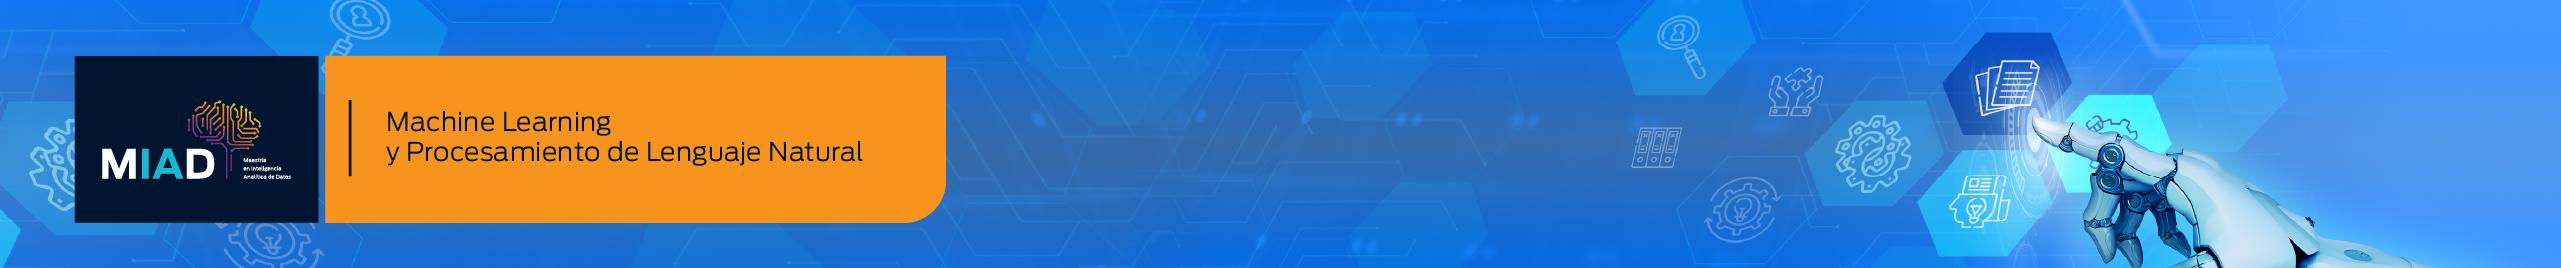

# Taller: Tokenización de textos  

En este taller podrán poner en práctica sus conocimientos sobre preprocesamiento de texto (tokenización). El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos detección de toxicidad en comentarios

En este taller se usará el conjunto de datos de detección de toxicidad en comentarios de la base de datos de Kaggle. Cada observación es un comentario que tiene como variable objetivo (target) la probabilidad de ser un comentario tóxico. El objetivo es predecir la toxicidad de cada comentario. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data).

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Importación librerías
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
%matplotlib inline

## Análisis de datos

In [9]:
# Carga de datos de archivos .csv
df = pd.read_csv('/Users/natalia/Documents/Master_IA/Machine_learning_2/Machine-Learning-NLP/Semana3/Toxicity/train.csv')
#df = df[['id','comment_text', 'target']]
df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,6101457,0.0,What are you talking about? What group do Pete...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,386454,approved,0,0,1,1,1,0.0,0,4
1,5342103,0.0,"NO!, Let him, we need a Conservative government.",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,339685,approved,0,0,0,3,0,0.0,0,4
2,743361,0.2,"Perhaps he took the ""power out of the Cardinal...",0.0,0.0,0.0,0.0,0.2,NaN,NaN,...,157996,approved,4,0,0,5,3,0.0,0,5
3,551008,0.0,"As always, yours is dripping with sarcasm, whi...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,149409,approved,0,0,0,0,0,0.0,0,4
4,865998,0.3,The dirty little secret is that the price rang...,0.0,0.0,0.0,0.3,0.0,0.0,0.0,...,162788,approved,0,0,0,1,0,0.0,4,10


### Null Value

In [10]:
pd.DataFrame(df.isnull().sum()/ df.shape[0])

,0
id,0.000000
target,0.000000
comment_text,0.000000
severe_toxicity,0.000000
obscene,0.000000
identity_attack,0.000000
insult,0.000000
threat,0.000000
asian,0.775842
atheist,0.775842


Se puede observar que existe muchos valores nulos, pero esto no importaria, debido a que solo tendremos en cuenta comment_text y target

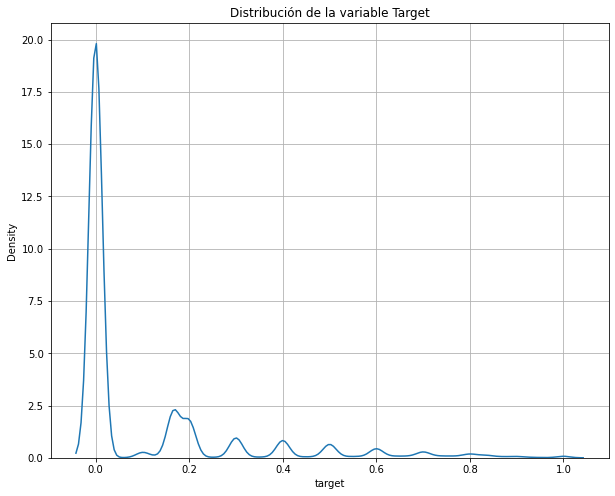

In [11]:
plt.figure(figsize=(10, 8))
sns.distplot(df['target'], kde=True, hist=False)
plt.title("Distribución de la variable Target")
plt.grid()
plt.show()

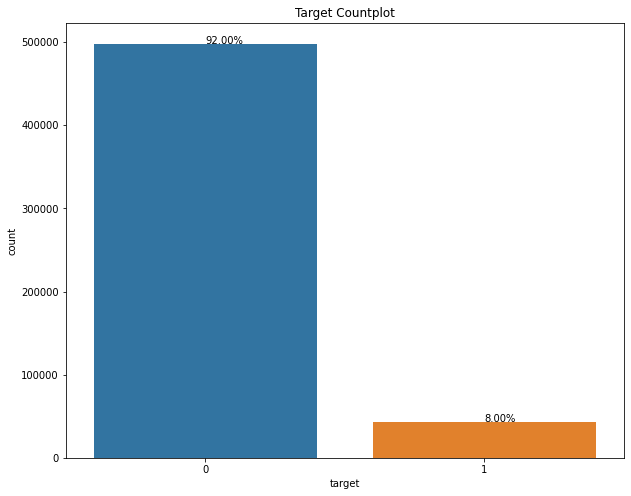

In [12]:
data = df['target'].apply(lambda x: 1 if x>=0.5 else 0)
total = float(len(data))


fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.countplot(data)
plt.title('Target Countplot')

for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.0, height+4, '{:1.2f}%'.format(100*height/total))

Como se puede observar los datos están desequilibrados. Solo hay un **8% de comentarios no tóxicos** y un **92% de comentarios tóxicos**.

In [13]:
# Separación de variable de interés (y)
y = df.target
y.describe()

count    541462.000000
mean          0.102991
std           0.196979
min           0.000000
25%           0.000000
50%           0.000000
75%           0.166667
max           1.000000
Name: target, dtype: float64

### Wordcloud of comment text

In [14]:
def show_wordcloud(data, title=None):
  wordcloud = WordCloud(
      background_color = 'white',
      stopwords = set(STOPWORDS),
      max_words = 50,
      scale = 5,
      random_state = 1
  ).generate(str(data))

  fig = plt.figure(figsize=(10, 10))
  plt.axis('off')
  if title:
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)

  plt.imshow(wordcloud)
  plt.show()

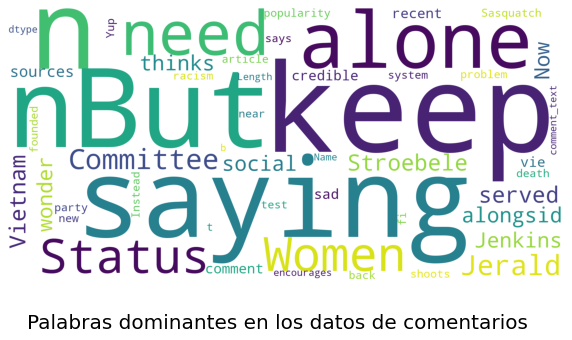

In [15]:
show_wordcloud(df['comment_text'].sample(20000), title="Palabras dominantes en los datos de comentarios")

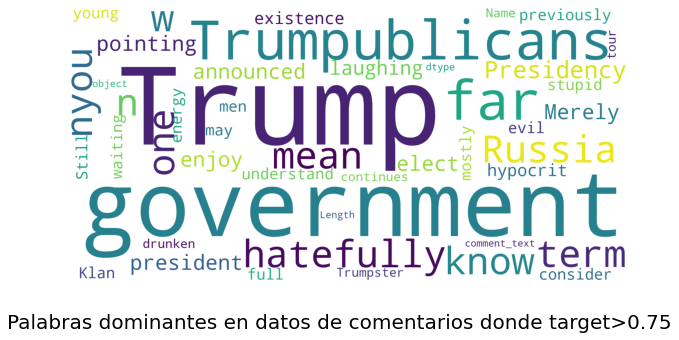

In [16]:
show_wordcloud(df[df['target'] > 0.75]['comment_text'].sample(10000), title="Palabras dominantes en datos de comentarios donde target>0.75")

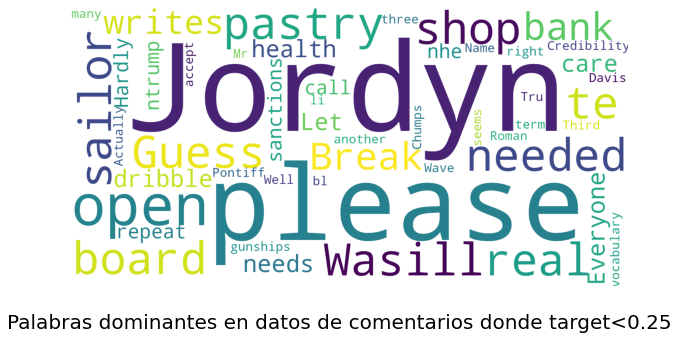

In [17]:
show_wordcloud(df[df['target'] < 0.25]['comment_text'].sample(20000), title="Palabras dominantes en datos de comentarios donde target<0.25")

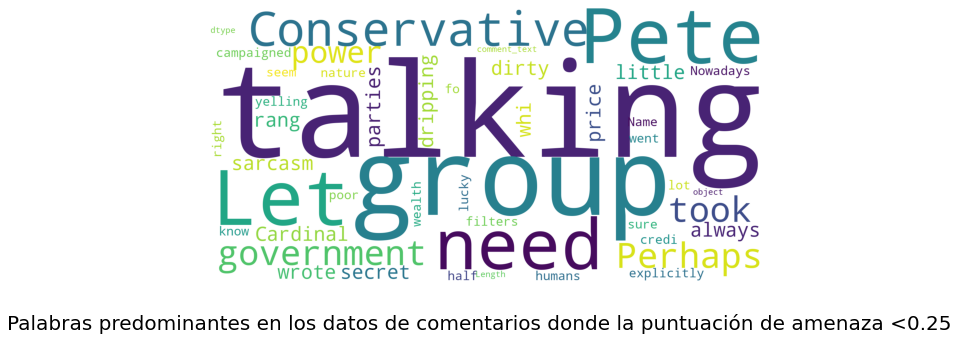

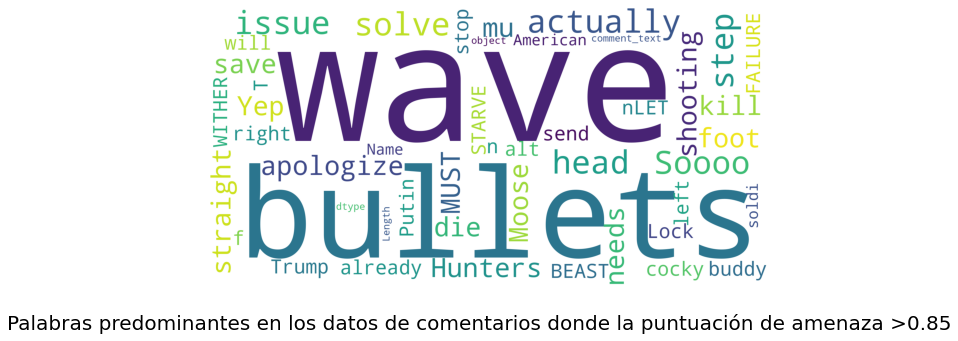

In [18]:
show_wordcloud(df[df['threat'] < 0.25]['comment_text'], title="Palabras predominantes en los datos de comentarios donde la puntuación de amenaza <0.25")
show_wordcloud(df[df['threat'] > 0.85]['comment_text'], title="Palabras predominantes en los datos de comentarios donde la puntuación de amenaza >0.85")

### Separación de datos en set de entrenamiento y test

In [19]:
# Separación de variables predictoras (X), solo se considera el texto de la noticia
X = df.comment_text
y = df.target

In [20]:
# Separación de datos en set de entrenamiento y test
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)

### Preprocesamiento Datos

In [21]:
import spacy
import re
from gensim.corpora.textcorpus import strip_multiple_whitespaces
nlp = spacy.load('en_core_web_lg')

In [24]:
def clean_text(texto: str):
    texto = texto.replace('\n', ' ') # remove line breaks
    texto = re.sub('\S*@\S*\s?', '', texto)  #remove emails 
    texto = re.sub(r'[0-9]+', '', texto) #remove numbers
    texto = re.sub('[^A-Za-z0-9]+', ' ', texto) #remove puntanction
    texto = strip_multiple_whitespaces(texto) #remove spaces
    filtered_words  = [token.text for token in nlp(texto) if token.is_stop == False]
    texto = ' '.join(filtered_words)
    return texto

In [25]:
# Train
xtrain = pd.DataFrame(xtrain, columns=['comment_text'])
process_clean = lambda x: clean_text(x)
xtrain['clean_comment_text'] = xtrain['comment_text'].apply(process_clean)

In [26]:
xtrain.head()

,comment_text,clean_comment_text
101388,Oral history is what ever they say it is. Naz...,Oral history Nazis eugenic experiments Native ...
187598,"Marijuana is less harmful to human health, tha...",Marijuana harmful human health cigarettes wide...
175087,Look and see how many women are in photos of t...,Look women photos White Supremecists women
521167,see like others we stood up to south africa ye...,like stood south africa years ago agree shame
343059,"And next, they'll be coming for ISIS.",ll coming ISIS


In [27]:
# Test
xtest = pd.DataFrame(xtest, columns=['comment_text'])
xtest['clean_comment_text'] = xtest['comment_text'].apply(process_clean)

In [ ]:
xtest.head()

## Punto 1 - Tokenización con CountVectorizer

En la celda 1 creen y entrenen el modelo de regresión de su preferencia, para que prediga la probabilidad de que un comentario sea tóxico, usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** para preprocesar los comentarios y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("model", SGDRegressor()),
    ]
)

parameters = {
    "vect__max_df": (0.5, 0.75, 1.0),
    'vect__max_features': (1000, 5000, 10000, 30000),
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams

    #"clf__max_iter": (50,),
    "clf__alpha": (0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100),
    "clf__penalty": ("l1","l2", "elasticnet"),
    'clf__max_iter': (10, 50, 80),
}

In [ ]:
# find the best parameters for both the feature extraction and the
# classifier
import time


grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:", parameters)

t0 = time()
grid_search.fit(data.data, data.target)
print("tiempo estimado %0.3fs" % (time() - t0))
print()

t0 = time()
grid_search.fit(data.data, data.target)
print("done in %0.3fs" % (time() - t0))
print()

In [ ]:
#Tokenization 
tokenizer = CountVectorizer(
    ngram_range=(1, 2),
    min_df=4, max_df=0.8,
    max_features=30000
)
#tokenizer.fit(xtrain['clean_comment_text'].values)
tokenizer.stop_words_ = {}

In [ ]:
train_toke = tokenizer.fit_transform(xtrain_final['clean_comment_text'].values)
test_toke = tokenizer.transform(xtest['clean_comment_text'].values)

In [ ]:
from sklearn.linear_model import SGDRegressor 

alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']

model = SGDRegressor(alpha=alpha[0], penalty=penalty[1]) 
model.fit(train_toke, ytrain) 

In [ ]:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
train_errors = []
test_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(train_toke, ytrain) 
        
        preds = model.predict(train_toke) 
        err = mean_squared_error(ytrain, preds) 
        train_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(test_toke) 
        err = mean_squared_error(ytest, preds) 
        test_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: 
            best_error = err
            best_model = model
        
        print("*"*20)

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(range(len(alpha) * len(penalty) ), train_errors)
plt.plot(range(len(alpha) * len(penalty)), val_errors)
plt.suptitle("Mean squared error vs Hyper parameter")
plt.legend(['train', 'val'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyper parameter(alpha + penalty )')
plt.ylabel("Mean squared error ")
plt.show()

## Punto 2 - Tokenización con CountVectorizer y trigramas

En la celda 2 creen y entrenen el mismo modelo de regresión del punto anterior (es decir si usaron un RandomForestRegresor usen nuevamente ese regresor), para que prediga la probabilidad de que un comentario sea tóxico, usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer **considerando trigramas** para preprocesar los comentarios y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
#Tokenization 
tokenizer2 = CountVectorizer(
    ngram_range=(1, 3),
    min_df=4, max_df=0.9,
    max_features=30000
)
#tokenizer.fit(xtrain['clean_comment_text'].values)
tokenizer2.stop_words_ = {}


In [ ]:
train_toke_2 = tokenizer2.fit_transform(xtrain_final['clean_comment_text'].values)
test_toke_2 = tokenizer2.transform(xtest['clean_comment_text'].values)

In [ ]:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks_2 = []
train_errors_2 = []
test_errors_2 = []
best_model_2 = None
best_error_2 = 100
for a in alpha:
    for p in penalty:
        xticks_2.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model_2 = SGDRegressor(alpha=a, penalty=p) 
        model_2.fit(train_toke_2, ytrain) 
        
        preds_2 = model.predict(train_toke_2) 
        err_2 = mean_squared_error(ytrain, preds_2) 
        train_errors_2.append(err_2)
        print("Mean Squared Error on train set: ", err_2)
        
        preds_2 = model.predict(test_toke_2) 
        err_2 = mean_squared_error(ytest, preds_2) 
        test_errors_2.append(err_2)
        print("Mean Squared Error on cv set: ", err_2)
        
        if err < best_error_2: 
            best_error_2 = err
            best_model_2 = model
        
        print("*"*20)

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(range(len(alpha) * len(penalty) ), train_errors_2)
plt.plot(range(len(alpha) * len(penalty)), test_errors_2)
plt.suptitle("Mean squared error vs Hyper parameter")
plt.legend(['train', 'val'])
plt.xticks(range(len(alpha) * len(penalty)), xticks_2, rotation=45)
plt.xlabel('Hyper parameter(alpha + penalty )')
plt.ylabel("Mean squared error ")
plt.show()

## Punto 3 - TfidfVectorizer

Investigen sobre la función TfidfVectorizer. En la celda de texto 3, expliquen en qué consiste esta técnica de tokenización (describanla y expliquen su funcionamiento) y cúales son las ventajas o deventajas de su uso al compararlo con la función CountVectorizer.

### Term Frequency Inverse Document Frequency (TFIDF)

TF-IDF significa Term Frequency — Inverse Document Frequency y es una estadística que tiene como objetivo definir mejor qué tan importante es una palabra para un documento, al tiempo que tiene en cuenta la relación con otros documentos del mismo corpus.

Esto se realiza observando cuántas veces aparece una palabra en un documento y, al mismo tiempo, prestando atención a cuántas veces aparece la misma palabra en otros documentos del corpus.

La razón detrás de esto es la siguiente:

* una palabra que aparece con frecuencia en un documento tiene más relevancia para ese documento, lo que significa que hay una mayor probabilidad de que el documento se trate o esté relacionado con esa palabra específica

* una palabra que aparece con frecuencia en más documentos puede impedirnos encontrar el documento correcto en una colección; la palabra es relevante para todos los documentos o para ninguno. De cualquier manera, no nos ayudará a filtrar un solo documento o un pequeño subconjunto de documentos del conjunto completo.

Entonces, TF-IDF es un puntaje que se aplica a cada palabra en cada documento en nuestro conjunto de datos. Y por cada palabra, el valor TF-IDF aumenta con cada aparición de la palabra en un documento, pero disminuye gradualmente con cada aparición en otros documentos. Y las matemáticas para eso están en la siguiente sección.


### Count Vectorizer

Count Vectorizer es una forma de convertir un conjunto dado de cadenas en una representación de frecuencia.

Los vectores de conteo pueden ser útiles para comprender el tipo de texto por la frecuencia de las palabras que contiene. Pero sus principales desventajas son:

* Su incapacidad para identificar palabras más importantes y menos importantes para el análisis.
* Solo considerará las palabras que abundan en un corpus como la palabra estadísticamente más significativa.
* Tampoco identifica las relaciones entre palabras, como la similitud lingüística entre palabras.

### Conclusion comparativa

TF-IDF es mejor que Count Vectorizers porque no solo se enfoca en la frecuencia de las palabras presentes en el corpus, sino que también proporciona la importancia de las palabras. Luego podemos eliminar las palabras que son menos importantes para el análisis, lo que hace que la construcción del modelo sea menos compleja al reducir las dimensiones de entrada.


### Parámetros importantes que debe conocer : la vectorización CountVectorizer y TFIDF de Sklearn:

**max_features:** este parámetro permite usar solo las 'n' palabras más frecuentes como características en lugar de todas las palabras. Se puede pasar un número entero para este parámetro.

**stop_words:** puede eliminar las palabras extremadamente comunes como 'esto', 'es', 'son', etc. usando este parámetro, ya que las palabras comunes agregan poco valor al modelo. Podemos establecer el parámetro en 'inglés' para usar una lista integrada. También podemos establecer este parámetro en una lista personalizada.

**analyzer:** este parámetro le dice al modelo si la función debe estar compuesta por n-gramas de palabras o n-gramas de caracteres. Podemos configurarlo para que sea 'word', 'char' o 'char_wb'. La opción 'char_wb' crea n-gramas de caracteres solo a partir del texto dentro de los límites de las palabras.

**ngram_range:** un n-grama es una cadena de palabras seguidas. Por ejemplo, en la oración: "El procesamiento de texto es fácil", 2 gramos podrían ser 'Procesamiento de texto', 'El procesamiento es' o 'Es fácil'. Podemos configurar ngram_range para que sea (x,y) donde x es el mínimo e y es el tamaño máximo de los n-gramas que queremos incluir en las funciones. El ngram_range predeterminado es (1,1).

**min_df, max_df:** Hacen referencia a la frecuencia mínima y máxima del documento que debe tener una palabra/n-grama para ser utilizada como característica. La frecuencia aquí se refiere a la proporción de documentos. Ambos parámetros deben establecerse en el rango de [0,1].

## Punto 4 - Tokenización con TfidfVectorizer

En la celda 4 creen y entrenen el mismo modelo de regresión del primer punto, para que prediga la probabilidad de que un comentario sea tóxico, usando los set de entrenamiento y test definidos anteriormente. Procesen los comentarios con la función **TfidfVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
#Tokenization 
tokenizer3 = TfidfVectorizer(
    ngram_range=(1, 3),
    min_df=5, max_df=0.8,
    max_features=30000
)
#tokenizer.fit(xtrain['clean_comment_text'].values)
tokenizer3.stop_words_ = {}

In [ ]:
train_toke_3 = tokenizer3.fit_transform(xtrain['clean_comment_text'].values)
test_toke_3 = tokenizer3.transform(xtest['clean_comment_text'].values)

In [ ]:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']

model3 = SGDRegressor(alpha= alpha[0], penalty=penalty[1]) 
model3.fit(train_toke_2, ytrain) 

In [ ]:
train_errors_3 = []
test_errors_3 = []

preds_train_3 = model.predict(train_toke_3) 
err_train_3 = mean_squared_error(ytrain, preds_train_3) 
train_errors_3.append(err_train)
print("Mean Squared Error on train set: ", err_train_3)

preds_test_3 = model.predict(test_toke) 
err_test_3 = mean_squared_error(ytest, preds_test_3) 
test_errors.append(err_test_3)
print("Mean Squared Error on cv set: ", err_test_3)

## Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos y comenten cómo el preprocesamiento de texto afecta el desempeño.

In [ ]:
# Celda 5